In [1]:
from pathlib import Path
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep 
plt.style.use(hep.style.ATLAS)
import awkward as ak
from tqdm import tqdm 
# import ROOT

In [2]:
ssWW_Ntuple_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/")
fit_input_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/")

In [3]:
Mjj_bin_edges = np.array([ 500.,  850., 1450., 2100., 2550., 3000.], dtype=float)
MT_bin_edges = np.array([0, 100, 180, 230, 280, 350, 500, 800, 1500], dtype=float)

mass_points1 = np.linspace(200, 550, int((550 - 200) / 25 + 1), dtype=int)
mass_points2 = np.linspace(600, 1000, int((1000 - 600) / 100 + 1), dtype=int)
mass_points3 = np.array([1500, 2000, 3000], dtype=int)
mass_points = np.concatenate([mass_points1, mass_points2, mass_points3])

period_labels = np.array(['a', 'd', 'e'])
dsid_map = dict.fromkeys(mass_points)
dsid_start = 511727 
for mass_idx, masss_point in enumerate(mass_points):
    dsid_map[masss_point] = dsid_start + mass_idx

ttree_prefix = 'HWWTree_'
ttree_channels = ['em', 'me', 'ee', 'mm']

# Signal

## FitInput 

### TH2D

In [3]:
th2_folder_path = fit_input_folder_path / "histograms_th2_step1"

In [4]:
sorted(th2_folder_path.glob("*.root"))

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th2_step1/fitInput220829_unblinded_MT_full_exp_theo_syst.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th2_step1/fitInput_GM_H5_20220908_MjjVSMT.root')]

In [5]:
fitInput_GM_H5_20220908_MjjVSMT_path = sorted(th2_folder_path.glob("*.root"))[1]
fitInput_GM_H5_20220908_MjjVSMT = uproot.open(fitInput_GM_H5_20220908_MjjVSMT_path)

In [8]:
sig_425_MjjVSMT = fitInput_GM_H5_20220908_MjjVSMT['CutSR']['run2/GM_H5_m425/all']['MjjVSMT_CutSR_run2_GM_H5_m425_all_nom'].to_hist()

/global/cfs/cdirs/atlas/hrzhao/miniconda3/envs/ml/lib/python3.9/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale


(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f91437a40a0>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f91437ca5e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f914016e0a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])

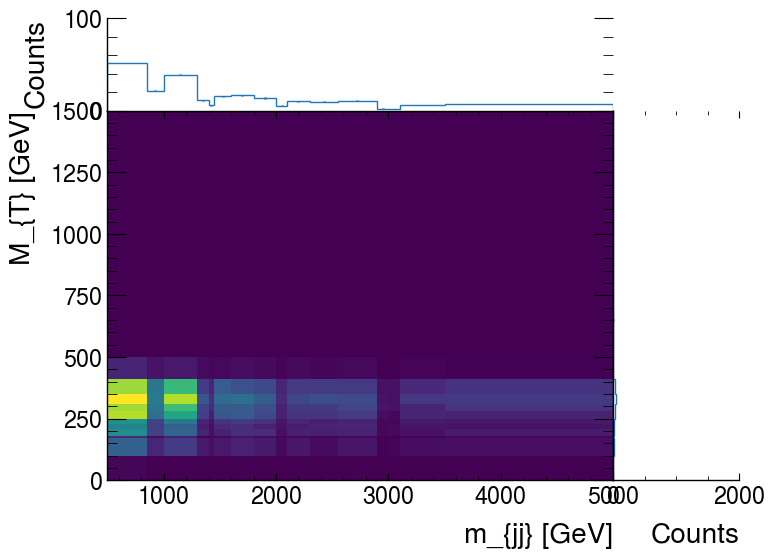

In [9]:
sig_425_MjjVSMT.plot2d_full()

### Read from the input TH1D

In [95]:
th1_folder_path = fit_input_folder_path / "histograms_th1_step2"

In [96]:
sig_th1_total_yields = dict.fromkeys(["MjjSRrun2all"])
for k, v in sig_th1_total_yields.items():
    sig_th1_total_yields[k] = dict.fromkeys(mass_points)

for mass_point in tqdm(mass_points):
    th1_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])
    # th1_MTSRrun2all = np.zeros_like(MT_bin_edges[:-1]) 

    for MT_bin_idx, MT_bin_left_edge in enumerate(MT_bin_edges[:-1]):
        th1_file_path = th1_folder_path / f"SigH5pp_m{mass_point}_MTBin{MT_bin_idx+1}.root"
        th1_file = uproot.open(th1_file_path) if th1_file_path.exists() else print(f"{th1_file_path} does not exist")
        # print(th1_file_path.name)
        _th1_MjjSRrun2all = th1_file['MjjSRrun2all'].to_numpy()
        _th1_MTSRrun2all = th1_file['MTSRrun2all'].to_numpy()
        assert np.allclose(_th1_MjjSRrun2all[1], Mjj_bin_edges)
        assert np.allclose(_th1_MTSRrun2all[1], MT_bin_edges)
        
        th1_MjjSRrun2all += _th1_MjjSRrun2all[0]
        # th1_MTSRrun2all += _th1_MTSRrun2all[0]
    
    sig_th1_total_yields["MjjSRrun2all"][mass_point] = th1_MjjSRrun2all
    # th1_total_yields["MTSRrun2all"][mass_point] = th1_MTSRrun2all
    

100%|██████████| 23/23 [00:11<00:00,  2.02it/s]


In [49]:
# list([nominal for nominal in th1_file.keys() if nominal.endswith('all;1')])

# ['MjjLowMjjMTBin8run2all;1',
#  'MjjLowMjjrun2all;1',
#  'MTLowMjjrun2all;1',
#  'MjjSRMTBin8run2all;1',
#  'MjjSRrun2all;1',
#  'MTSRrun2all;1',
#  'MjjCutCRWZrun2all;1']

# th1_file['MjjSRMTBin8run2all'].to_hist() == th1_file['MjjSRrun2all'].to_hist()

In [97]:
df_sig_th1_MjjSRrun2all = pd.DataFrame(sig_th1_total_yields["MjjSRrun2all"])
df_sig_th1_MjjSRrun2all.loc["Total"] = df_sig_th1_MjjSRrun2all.sum(axis=0)
df_sig_th1_MjjSRrun2all["sum"] = df_sig_th1_MjjSRrun2all.sum(axis=1)
# df_sig_th1_MTSRrun2all = pd.DataFrame(_sig_th1_total_yields["MTSRrun2all"])

In [98]:
df_sig_th1_MjjSRrun2all

,200,225,250,275,300,325,350,375,400,425,...,550,600,700,800,900,1000,1500,2000,3000,sum
0,92.810727,101.315187,86.149324,88.336161,76.917861,78.801568,64.328994,60.168044,53.978021,51.860760,...,28.880748,24.236491,15.690693,11.172470,1.966524,1.410196,0.294479,0.079840,0.027257,993.565298
1,111.019388,120.353108,110.386333,113.260281,101.186007,103.827147,91.199030,88.270828,80.937147,77.610073,...,52.779630,43.846988,32.250358,23.522765,4.314806,3.169040,0.800775,0.212728,0.077419,1412.898151
2,62.329668,67.078297,61.555801,65.276106,59.686267,65.026797,57.110884,57.722205,51.172899,51.197725,...,36.992046,33.211554,26.316132,19.621661,3.798858,2.925309,0.835937,0.250618,0.100597,899.608251
3,21.495762,26.114925,23.463262,25.288798,21.711352,23.916620,22.651849,22.569353,21.199470,19.797921,...,15.565416,14.155319,10.789020,9.084329,1.744141,1.355465,0.413324,0.135002,0.055071,351.841368
4,28.548871,33.312486,28.529062,34.137902,31.059523,32.502024,29.573774,31.294695,27.876511,29.980077,...,22.558626,20.624628,16.758825,13.855394,2.678756,2.247385,0.732480,0.231637,0.091329,488.467199
Total,316.204415,348.174002,310.083782,326.299249,290.561010,304.074154,264.864532,260.025123,235.164047,230.446556,...,156.776465,136.074980,101.805028,77.256619,14.503084,11.107396,3.076995,0.909824,0.351672,4146.380267


### Read from txt prefityieldshpp.txt

In [57]:
import pandas as pd
import ast
import re

name_strings = "H^{#pm#pm}(200)"


with open('prefityieldshpp.txt', 'r') as file:
    file_contents = file.read()

prefityieldshpp_data = {}
lines = file_contents.split('\n')

for line in lines:
    if line.startswith('  - Name'):
        name_strings = line.split(':')[1].strip()
        digits = re.findall(r'\((\d+)\)', name_strings)
        if digits:
            digits = int(digits[0])
    elif line.startswith('    Yield'):
        yield_str = line.split(':')[1].strip()
        yield_list = ast.literal_eval(yield_str)
        # row = {'Name': name, 'Yield': yield_list}
        prefityieldshpp_data[digits] = yield_list

# df = pd.DataFrame(data)

In [58]:
df_sig_txt_MjjSRrun2all = pd.DataFrame(prefityieldshpp_data)

In [60]:
df_sig_txt_MjjSRrun2all

,200,225,250,275,300,325,350,375,400,425,...,525,550,600,700,800,900,1000,1500,2000,3000
0,92.810727,101.315187,86.149324,88.336161,76.917861,78.801568,64.328994,60.168044,53.978021,51.860760,...,33.110384,28.880748,24.236491,15.690693,11.172470,1.966524,1.410196,0.294479,0.079840,0.027257
1,111.019388,120.353108,110.386333,113.260281,101.186007,103.827147,91.199030,88.270828,80.937147,77.610073,...,57.746940,52.779630,43.846988,32.250358,23.522765,4.314806,3.169040,0.800775,0.212728,0.077419
2,62.329668,67.078297,61.555801,65.276106,59.686267,65.026797,57.110884,57.722205,51.172899,51.197725,...,39.716087,36.992046,33.211554,26.316132,19.621661,3.798858,2.925309,0.835937,0.250618,0.100597
3,21.495762,26.114925,23.463262,25.288798,21.711352,23.916620,22.651849,22.569353,21.199470,19.797921,...,16.118536,15.565416,14.155319,10.789020,9.084329,1.744141,1.355465,0.413324,0.135002,0.055071
4,28.548871,33.312486,28.529062,34.137902,31.059523,32.502024,29.573774,31.294695,27.876511,29.980077,...,23.531400,22.558626,20.624628,16.758825,13.855394,2.678756,2.247385,0.732480,0.231637,0.091329


### Compare yields from TH1 and txt

In [61]:
np.allclose(df_sig_th1_MjjSRrun2all, df_sig_txt_MjjSRrun2all)

True

## NTuple

Here we have a,d,e at a same mass point.   
And the dsid should be matched.  

### Yields

In [91]:
higgspp_folder_path = ssWW_Ntuple_folder_path / "higgspp" 
# sorted(higgspp_folder_path.glob("*.root"))
# ntuple_total_yields = dict.fromkeys(["MjjSRrun2all", "MTSRrun2all"])
sig_ntuple_total_yields = dict.fromkeys(["MjjSRrun2all"])

for k, v in sig_ntuple_total_yields.items():
    sig_ntuple_total_yields[k] = dict.fromkeys(mass_points)

for mass_point in tqdm(mass_points):
    sig_ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])
    # ntuple_MTSRrun2all = np.zeros_like(MT_bin_edges[:-1]) 

    for period_label in period_labels:
        sig_m_period_path = higgspp_folder_path / f"{dsid_map[mass_point]}_full_run2_sig_X_mc16{period_label}_EWK_GM_H5_m{mass_point}.root"
        # print(sig_m_path.name)
        sig_m_period = uproot.open(sig_m_period_path) if sig_m_period_path.exists() else print(f"{sig_m_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_sig_m_period_channel = sig_m_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_sig_m_period_channel['mjj'] = df_sig_m_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_sig_m_period_channel['mjj_bin_idx'] = pd.cut(df_sig_m_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_sig_m_period_channel['mjj_bin_idx'] = np.digitize(df_sig_m_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_sig_m_period_channel['mjj_bin_idx']==5
            df_sig_m_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            sig_ntuple_MjjSRrun2all += df_sig_m_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

    sig_ntuple_total_yields["MjjSRrun2all"][mass_point] = sig_ntuple_MjjSRrun2all

100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


In [92]:
df_sig_ntuple_MjjSRrun2all = pd.DataFrame(sig_ntuple_total_yields["MjjSRrun2all"])

In [94]:
df_sig_ntuple_MjjSRrun2all.loc["Total"] = df_sig_ntuple_MjjSRrun2all.sum(axis=0)
df_sig_ntuple_MjjSRrun2all["sum"] = df_sig_ntuple_MjjSRrun2all.sum(axis=1)
df_sig_ntuple_MjjSRrun2all

,200,225,250,275,300,325,350,375,400,425,...,550,600,700,800,900,1000,1500,2000,3000,sum
0,92.810728,101.315187,86.149327,88.336164,76.917861,78.801570,64.328996,60.168043,53.978018,51.860761,...,28.880747,24.236491,15.690694,11.172471,1.966524,1.410196,0.294479,0.079840,0.027257,993.565304
1,111.019387,120.353107,110.386333,113.260280,101.186005,103.827146,91.199029,88.270827,80.937147,77.610075,...,52.779630,43.846989,32.250357,23.522765,4.314806,3.169040,0.800775,0.212728,0.077419,1412.898147
2,62.329669,67.078297,61.555800,65.276107,59.686267,65.026797,57.110884,57.722205,51.172899,51.197725,...,36.992045,33.211554,26.316132,19.621661,3.798858,2.925309,0.835937,0.250618,0.100597,899.608252
3,21.495762,26.114925,23.463262,25.288798,21.711353,23.916620,22.651849,22.569353,21.199470,19.797922,...,15.565416,14.155319,10.789020,9.084328,1.744141,1.355465,0.413324,0.135002,0.055071,351.841370
4,28.548871,33.312486,28.529062,34.137901,31.059523,32.502023,29.573775,31.294694,27.876511,29.980077,...,22.558626,20.624628,16.758825,13.855394,2.678756,2.247385,0.732480,0.231637,0.091329,488.467197
Total,316.204417,348.174002,310.083783,326.299250,290.561009,304.074156,264.864532,260.025123,235.164044,230.446559,...,156.776465,136.074981,101.805028,77.256619,14.503084,11.107396,3.076995,0.909824,0.351672,4146.380271


In [68]:
df_sig_th1_MjjSRrun2all

,200,225,250,275,300,325,350,375,400,425,...,525,550,600,700,800,900,1000,1500,2000,3000
0,92.810727,101.315187,86.149324,88.336161,76.917861,78.801568,64.328994,60.168044,53.978021,51.860760,...,33.110384,28.880748,24.236491,15.690693,11.172470,1.966524,1.410196,0.294479,0.079840,0.027257
1,111.019388,120.353108,110.386333,113.260281,101.186007,103.827147,91.199030,88.270828,80.937147,77.610073,...,57.746940,52.779630,43.846988,32.250358,23.522765,4.314806,3.169040,0.800775,0.212728,0.077419
2,62.329668,67.078297,61.555801,65.276106,59.686267,65.026797,57.110884,57.722205,51.172899,51.197725,...,39.716087,36.992046,33.211554,26.316132,19.621661,3.798858,2.925309,0.835937,0.250618,0.100597
3,21.495762,26.114925,23.463262,25.288798,21.711352,23.916620,22.651849,22.569353,21.199470,19.797921,...,16.118536,15.565416,14.155319,10.789020,9.084329,1.744141,1.355465,0.413324,0.135002,0.055071
4,28.548871,33.312486,28.529062,34.137902,31.059523,32.502024,29.573774,31.294695,27.876511,29.980077,...,23.531400,22.558626,20.624628,16.758825,13.855394,2.678756,2.247385,0.732480,0.231637,0.091329


In [69]:
df_sig_ntuple_MjjSRrun2all - df_sig_th1_MjjSRrun2all 

,200,225,250,275,300,325,350,375,400,425,...,525,550,600,700,800,900,1000,1500,2000,3000
0,8.471408e-07,-4.224078e-07,3.213942e-06,2.401203e-06,-3.050487e-07,1.977444e-06,1.265698e-06,-6.054442e-07,-2.581708e-06,5.525346e-07,...,1.068416e-07,-1.567616e-07,2.824963e-07,7.044339e-08,6.280320e-08,3.301426e-08,1.341520e-09,7.813578e-09,-9.963571e-10,-2.694581e-09
1,-1.763416e-07,-8.240945e-07,-3.361488e-07,-1.085527e-06,-1.408553e-06,-5.798403e-07,-1.260588e-06,-6.753003e-07,1.216596e-07,1.378413e-06,...,-1.309655e-07,4.036237e-08,5.372363e-07,-3.813120e-07,-9.435146e-08,-5.792214e-08,-1.934115e-08,1.929412e-09,8.574455e-09,3.965408e-10
2,7.609442e-07,6.121471e-07,-7.407467e-07,1.755239e-07,-3.534104e-07,5.489576e-08,3.149819e-07,5.226400e-07,-5.190898e-07,8.091401e-07,...,3.858039e-07,-3.885210e-07,-5.779140e-07,-1.960454e-07,4.570086e-07,8.642036e-08,1.661704e-08,-9.450189e-09,-1.519041e-09,-1.101228e-09
3,2.680156e-07,2.002136e-07,-3.138379e-07,-4.823108e-08,3.257550e-07,1.672382e-07,3.187559e-07,2.974351e-07,4.780838e-08,2.223041e-07,...,-5.924629e-07,3.358290e-07,3.052923e-07,-8.823022e-09,-3.725989e-07,-1.061385e-08,1.312763e-10,8.112747e-10,-1.216703e-09,3.573056e-10
4,-3.046887e-07,-1.370448e-07,-2.688729e-07,-1.189830e-06,3.424271e-07,-1.344028e-07,1.966137e-07,-1.666686e-07,-2.633331e-07,-4.566782e-08,...,4.701691e-08,2.854325e-07,3.445132e-07,-1.308151e-07,1.555451e-07,6.446234e-08,-2.896372e-09,-3.474629e-08,-5.875223e-09,2.416878e-09


In [71]:
np.allclose(df_sig_ntuple_MjjSRrun2all, df_sig_th1_MjjSRrun2all)

True

# Background

In [4]:
th1_folder_path = fit_input_folder_path / "histograms_th1_step2"
sorted(th1_folder_path.glob("*.root"))

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/ChFlip.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/Data.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/SigEWLOMGH7_MTBin1.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/SigEWLOMGH7_MTBin2.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/SigEWLOMGH7_MTBin3.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/SigEWLOMGH7_MTBin4.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms

In [5]:
sorted(ssWW_Ntuple_folder_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_WZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/data'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8')]

We have(according to the Ntuple lists): 
1. WZ  
   - WZ_EW  
   - WZ_QCD
2. Wgamma
3. ZZ
4. Zgamma 
5. fakes 
6. LOMGH7
7. LOMGPy8(Not used in FitInput)


And 
data

## WZ

### FitInput

In [30]:
bkg_WZ_th1_variants = ["EW", "QCD"]
bkg_WZ_th1_keys = ["WZ_" + bkg_WZ_th1_variant for bkg_WZ_th1_variant in bkg_WZ_th1_variants]
bkg_WZ_th1 = dict.fromkeys(bkg_WZ_th1_keys)

for bkg_WZ_th1_variant in bkg_WZ_th1_variants:
    WZ_var_file_path = th1_folder_path / f"WZ_{bkg_WZ_th1_variant}.root"
    WZ_var_file = uproot.open(WZ_var_file_path) if WZ_var_file_path.exists() else print(f"{WZ_var_file_path} does not exist")
    _bkg_MjjSRrun2_all = WZ_var_file['MjjSRrun2all'].to_numpy()
    bkg_WZ_th1["WZ_" + bkg_WZ_th1_variant] = _bkg_MjjSRrun2_all[0]


In [36]:
df_bkg_WZ_th1 = pd.DataFrame(bkg_WZ_th1)
df_bkg_WZ_th1.loc["Total"] = df_bkg_WZ_th1.sum()
df_bkg_WZ_th1

,WZ_EW,WZ_QCD
0,4.802661,55.164879
1,5.200336,22.351132
2,2.679551,4.202310
3,1.074043,0.671657
4,1.181635,0.415642
Total,14.938226,82.805621


In [29]:
# list([nominal for nominal in all_hists if nominal.endswith('all;1')])

# ['MjjLowMjjMTBin1run2all;1',
#  'MjjLowMjjMTBin2run2all;1',
#  'MjjLowMjjMTBin3run2all;1',
#  'MjjLowMjjMTBin4run2all;1',
#  'MjjLowMjjMTBin5run2all;1',
#  'MjjLowMjjMTBin6run2all;1',
#  'MjjLowMjjMTBin7run2all;1',
#  'MjjLowMjjMTBin8run2all;1',
#  'MjjLowMjjrun2all;1',
#  'MTLowMjjrun2all;1',
#  'MjjSRMTBin1run2all;1',
#  'MjjSRMTBin2run2all;1',
#  'MjjSRMTBin3run2all;1',
#  'MjjSRMTBin4run2all;1',
#  'MjjSRMTBin5run2all;1',
#  'MjjSRMTBin6run2all;1',
#  'MjjSRMTBin7run2all;1',
#  'MjjSRMTBin8run2all;1',
#  'MjjSRrun2all;1',
#  'MTSRrun2all;1',
#  'MjjCutCRWZrun2all;1']

### Ntuple

In [37]:
bkg_WZ_ntuple_path = ssWW_Ntuple_folder_path / "background_WZ/"
bkg_WZ_ntuple_variants = ['MGH7EG_WZEW', 'MGPy8EG_WZEW', 'MGPy8EG_WZINT', 'SHERPA222_WZQCD']

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_WZ_ntuple_total_yields = dict.fromkeys(bkg_WZ_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_WZ_variant in tqdm(bkg_WZ_ntuple_variants):
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_WZ_ntuple_path / f"background_mc16{period_label}_{bkg_WZ_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_WZ_ntuple_total_yields[bkg_WZ_variant] = ntuple_MjjSRrun2all


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


In [41]:
df_bkg_WZ_ntuple = pd.DataFrame(bkg_WZ_ntuple_total_yields)

In [42]:
df_bkg_WZ_ntuple.loc["Total"] = df_bkg_WZ_ntuple.sum()

In [44]:
df_bkg_WZ_ntuple[["MGPy8EG_WZEW", "SHERPA222_WZQCD", "MGH7EG_WZEW", "MGPy8EG_WZINT"]]

,MGPy8EG_WZEW,SHERPA222_WZQCD,MGH7EG_WZEW,MGPy8EG_WZINT
0,4.795208,55.144197,5.097928,0.090868
1,5.193438,22.325393,5.117635,0.109053
2,2.687041,4.190162,2.682167,0.043101
3,1.089067,0.677029,0.865811,0.011159
4,1.186672,0.416229,1.087570,0.011722
Total,14.951426,82.753011,14.851111,0.265903


In [45]:
df_bkg_WZ_th1

,WZ_EW,WZ_QCD
0,4.802661,55.164879
1,5.200336,22.351132
2,2.679551,4.202310
3,1.074043,0.671657
4,1.181635,0.415642
Total,14.938226,82.805621


## Wgamma

### FitInput

In [46]:
bkg_Wgamma_th1_path = th1_folder_path / "Wgamma.root"
bkg_Wgamma_th1 = uproot.open(bkg_Wgamma_th1_path) if bkg_Wgamma_th1_path.exists() else print(f"{bkg_Wgamma_th1_path} does not exist")

df_bkg_Wgamma_th1 = pd.DataFrame({"Wgamma" : bkg_Wgamma_th1['MjjSRrun2all'].to_numpy()[0]})
df_bkg_Wgamma_th1.loc["Total"] = df_bkg_Wgamma_th1.sum()
df_bkg_Wgamma_th1


,Wgamma
0,5.369484
1,4.198520
2,0.622816
3,0.053835
4,0.127181
Total,10.371836


### Ntuple

In [47]:
bkg_Wgamma_ntuple_path = ssWW_Ntuple_folder_path / "background_Wgamma/"
sorted(bkg_Wgamma_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16a_MGPy8_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16a_SHERPA2211_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16d_MGPy8_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16d_SHERPA2211_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16e_MGPy8_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_mc16e_SHERPA2211_Wgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma/background_run2

In [48]:
bkg_Wgamma_ntuple_path = ssWW_Ntuple_folder_path / "background_Wgamma/"
bkg_Wgamma_ntuple_variants = ['MGPy8_Wgamma', 'SHERPA2211_Wgamma']

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_Wgamma_ntuple_total_yields = dict.fromkeys(bkg_Wgamma_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_Wgamma_ntuple_variant in bkg_Wgamma_ntuple_variants:
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_Wgamma_ntuple_path / f"background_mc16{period_label}_{bkg_Wgamma_ntuple_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_Wgamma_ntuple_total_yields[bkg_Wgamma_ntuple_variant] = ntuple_MjjSRrun2all



In [51]:
df_bkg_Wgamma_ntuple = pd.DataFrame(bkg_Wgamma_ntuple_total_yields)
df_bkg_Wgamma_ntuple.loc["Total"] = df_bkg_Wgamma_ntuple.sum()
df_bkg_Wgamma_ntuple[["SHERPA2211_Wgamma", "MGPy8_Wgamma"]]

,SHERPA2211_Wgamma,MGPy8_Wgamma
0,4.955752,1.143416
1,4.482585,0.767628
2,0.257884,0.277187
3,-0.050446,0.000000
4,0.048125,0.000000
Total,9.693901,2.188231


## ZZ

### FitInput

In [52]:
bkg_ZZ_th1_path = th1_folder_path / "ZZ.root"
bkg_ZZ_th1 = uproot.open(bkg_ZZ_th1_path) if bkg_ZZ_th1_path.exists() else print(f"{bkg_ZZ_th1_path} does not exist")

df_bkg_ZZ_th1 = pd.DataFrame({"ZZ" : bkg_ZZ_th1['MjjSRrun2all'].to_numpy()[0]})
df_bkg_ZZ_th1.loc["Total"] = df_bkg_ZZ_th1.sum()
df_bkg_ZZ_th1

,ZZ
0,1.358809
1,0.720176
2,0.215347
3,0.080077
4,0.062699
Total,2.437108


### Ntuple 

In [53]:
bkg_ZZ_ntuple_path = ssWW_Ntuple_folder_path / "background_ZZ/"
sorted(bkg_ZZ_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ/background_mc16a_SHERPA_ZZ.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ/background_mc16d_SHERPA_ZZ.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ/background_mc16e_SHERPA_ZZ.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ/background_run2_SHERPA_ZZ.root')]

In [54]:
bkg_ZZ_ntuple_variants = ['SHERPA_ZZ']

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_ZZ_ntuple_total_yields = dict.fromkeys(bkg_ZZ_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_ZZ_ntuple_variant in bkg_ZZ_ntuple_variants:
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_ZZ_ntuple_path / f"background_mc16{period_label}_{bkg_ZZ_ntuple_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_ZZ_ntuple_total_yields[bkg_ZZ_ntuple_variant] = ntuple_MjjSRrun2all


In [55]:
df_bkg_ZZ_ntuple = pd.DataFrame(bkg_ZZ_ntuple_total_yields)
df_bkg_ZZ_ntuple.loc["Total"] = df_bkg_ZZ_ntuple.sum()
df_bkg_ZZ_ntuple

,SHERPA_ZZ
0,1.391278
1,0.745792
2,0.223147
3,0.084882
4,0.064382
Total,2.509481


## Zgamma 

### FitInput

In [56]:
bkg_Zgamma_th1_path = th1_folder_path / "Zgamma.root"
bkg_Zgamma_th1 = uproot.open(bkg_Zgamma_th1_path) if bkg_Zgamma_th1_path.exists() else print(f"{bkg_Zgamma_th1_path} does not exist")

df_bkg_Zgamma_th1 = pd.DataFrame({"Zgamma" : bkg_Zgamma_th1['MjjSRrun2all'].to_numpy()[0]})
df_bkg_Zgamma_th1.loc["Total"] = df_bkg_Zgamma_th1.sum()
df_bkg_Zgamma_th1

,Zgamma
0,0.675337
1,0.140733
2,0.000001
3,0.000000
4,0.000000
Total,0.816070


### Ntuple 

In [57]:
bkg_Zgamma_ntuple_path = ssWW_Ntuple_folder_path / "background_Zgamma/"
sorted(bkg_Zgamma_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16a_MGPy8_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16a_SHERPA2211_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16d_MGPy8_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16d_SHERPA2211_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16e_MGPy8_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_mc16e_SHERPA2211_Zgamma.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma/background_run2

In [58]:
bkg_Zgamma_ntuple_variants = ['MGPy8_Zgamma', 'SHERPA2211_Zgamma']

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_Zgamma_ntuple_total_yields = dict.fromkeys(bkg_Zgamma_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_Zgamma_ntuple_variant in bkg_Zgamma_ntuple_variants:
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_Zgamma_ntuple_path / f"background_mc16{period_label}_{bkg_Zgamma_ntuple_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_Zgamma_ntuple_total_yields[bkg_Zgamma_ntuple_variant] = ntuple_MjjSRrun2all

In [60]:
df_bkg_Zgamma_ntuple = pd.DataFrame(bkg_Zgamma_ntuple_total_yields)
df_bkg_Zgamma_ntuple.loc["Total"] = df_bkg_Zgamma_ntuple.sum()
df_bkg_Zgamma_ntuple[["SHERPA2211_Zgamma", "MGPy8_Zgamma"]]

,SHERPA2211_Zgamma,MGPy8_Zgamma
0,0.643014,0.055937
1,0.186446,0.001381
2,-0.272913,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
Total,0.556548,0.057317


## Fakes

### FitInput

In [61]:
bkg_fakes_th1_variants = ["eFakes", "mFakes"]

bkg_fakes_th1 = dict.fromkeys(bkg_fakes_th1_variants)

for bkg_fakes_th1_variant in bkg_fakes_th1_variants:
    bkg_var_th1_file_path = th1_folder_path / f"{bkg_fakes_th1_variant}.root"
    bkg_var_th1_file = uproot.open(bkg_var_th1_file_path) if bkg_var_th1_file_path.exists() else print(f"{bkg_var_th1_file_path} does not exist")
    bkg_var_th1_MjjSRrun2_all = bkg_var_th1_file['MjjSRrun2all'].to_numpy()
    bkg_fakes_th1[bkg_fakes_th1_variant] = bkg_var_th1_MjjSRrun2_all[0]

In [62]:
df_bkg_fakes_th1 = pd.DataFrame(bkg_fakes_th1)
df_bkg_fakes_th1.loc["Total"] = df_bkg_fakes_th1.sum()
df_bkg_fakes_th1

,eFakes,mFakes
0,13.506376,18.486689
1,7.047841,9.035747
2,0.000001,3.294020
3,2.537443,1.381199
4,0.000001,0.445051
Total,23.091662,32.642706


### Ntuple

In [63]:
bkg_fakes_ntuple_path = ssWW_Ntuple_folder_path / "background_fakes/"
sorted(bkg_fakes_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes/background_mc16a_ddFakes.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes/background_mc16d_ddFakes.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes/background_mc16e_ddFakes.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes/background_run2_ddFakes.root')]

In [64]:
bkg_fakes_ntuple_variants = ['ddFakes']

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_fakes_ntuple_total_yields = dict.fromkeys(bkg_fakes_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_fakes_ntuple_variant in bkg_fakes_ntuple_variants:
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_fakes_ntuple_path / f"background_mc16{period_label}_{bkg_fakes_ntuple_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_fakes_ntuple_total_yields[bkg_fakes_ntuple_variant] = ntuple_MjjSRrun2all


In [65]:
df_bkg_fakes_ntuple = pd.DataFrame(bkg_fakes_ntuple_total_yields)
df_bkg_fakes_ntuple.loc["Total"] = df_bkg_fakes_ntuple.sum()
df_bkg_fakes_ntuple

,ddFakes
0,35.206315
1,20.367338
2,5.639619
3,4.592264
4,0.446704
Total,66.252239


## SM WW 

### FitInput

In [12]:
# SigEWLOMGH7_MTBin*
# SigINTLOMGH7_MTBin*
# SigQCDLOMGH7.root
# SigEWLOMGH7_MTBin1
# SigINTLOMGH7_MTBin1
# SigQCDLOMGH7

bkg_SMWW_th1_variants = ["QCD", "EW", "INT"]
bkg_SMWW_th1 = dict.fromkeys(bkg_SMWW_th1_variants)

for bkg_SMWW_th1_variant in bkg_SMWW_th1_variants:
    if bkg_SMWW_th1_variant == "QCD":
        bkg_th1_var_file_path = th1_folder_path / f"Sig{bkg_SMWW_th1_variant}LOMGH7.root"
        bkg_th1_var_file = uproot.open(bkg_th1_var_file_path) if bkg_th1_var_file_path.exists() else print(f"{bkg_th1_var_file_path} does not exist")
        bkg_SMWW_th1[bkg_SMWW_th1_variant] = bkg_th1_var_file['MjjSRrun2all'].to_numpy()[0]
    else:
        bkg_th1_MjjSRrun2_all = np.zeros_like(Mjj_bin_edges[:-1])
        for mt_bin_idx, mt_bin in enumerate(MT_bin_edges[:-1]):
            bkg_th1_var_file_path = th1_folder_path / f"Sig{bkg_SMWW_th1_variant}LOMGH7_MTBin{mt_bin_idx+1}.root"
            bkg_th1_var_file = uproot.open(bkg_th1_var_file_path) if bkg_th1_var_file_path.exists() else print(f"{bkg_th1_var_file_path} does not exist")
            bkg_th1_MjjSRrun2_all += bkg_th1_var_file['MjjSRrun2all'].to_numpy()[0]
        bkg_SMWW_th1[bkg_SMWW_th1_variant] = bkg_th1_MjjSRrun2_all


In [66]:
df_bkg_SMWW_th1 = pd.DataFrame(bkg_SMWW_th1)
df_bkg_SMWW_th1.loc["Total"] = df_bkg_SMWW_th1.sum()

In [67]:
df_bkg_SMWW_th1

,QCD,EW,INT
0,14.468197,63.116388,2.892879
1,7.292054,81.838445,2.810500
2,1.701707,48.123715,1.214563
3,0.357293,17.896517,0.352249
4,0.222745,23.924852,0.323956
Total,24.041996,234.899917,7.594148


### Ntuple

In [19]:
bkg_SMWW_LGMH7_ntuple_path = ssWW_Ntuple_folder_path / "signal_LOMGH7/"
sorted(bkg_SMWW_LGMH7_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16a_500989_LOMGH7_EW.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16a_500990_LOMGH7_QCD.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16a_500991_LOMGH7_INT.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16d_500989_LOMGH7_EW.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16d_500990_LOMGH7_QCD.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16d_500991_LOMGH7_INT.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7/signal_mc16e_500989_LOMGH7_EW.root'),
 PosixPath('/glo

In [21]:
bkg_SMWW_ntuple_variants = ["QCD", "EW", "INT"]
dsid_bkg_SMWW_map = {"EW": 500989, "QCD":500990, "INT":500991}

# # sorted(higgspp_folder_path.glob("*.root"))
bkg_SMWW_ntuple_total_yields = dict.fromkeys(bkg_SMWW_ntuple_variants)

# print(bkg_WZ_file_path)

for bkg_SMWW_ntuple_variant in bkg_SMWW_ntuple_variants:
    ntuple_MjjSRrun2all = np.zeros_like(Mjj_bin_edges[:-1])

    for period_label in period_labels:
        bkg_period_path = bkg_SMWW_LGMH7_ntuple_path / f"signal_mc16{period_label}_{dsid_bkg_SMWW_map[bkg_SMWW_ntuple_variant]}_LOMGH7_{bkg_SMWW_ntuple_variant}.root"
        bkg_period = uproot.open(bkg_period_path) if bkg_period_path.exists() else print(f"{bkg_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period_channel = bkg_period[ttree_name].arrays(filter_name=['mjj', 'weight'],library="pd")
            # change the unit of mjj from MeV to GeV 
            df_bkg_period_channel['mjj'] = df_bkg_period_channel['mjj'] / 1000
            # add a new column to store the bin index of mjj
            # df_bkg_period_channel['mjj_bin_idx'] = pd.cut(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)
            df_bkg_period_channel['mjj_bin_idx'] = np.digitize(df_bkg_period_channel['mjj'], bins=Mjj_bin_edges) - 1
            
            # adjust the overflow bin index to the last bin
            overflow_idx = df_bkg_period_channel['mjj_bin_idx']==5
            df_bkg_period_channel.loc[overflow_idx, 'mjj_bin_idx'] = len(Mjj_bin_edges) - 2
            weight_yield_bins = df_bkg_period_channel.groupby('mjj_bin_idx')['weight'].sum().to_numpy()

            # add zero bins to the end of the array if the array length is less than 5 
            # this happends when 0 events are found in the last bin
            while weight_yield_bins.shape[0] < 5:
                weight_yield_bins = np.append(weight_yield_bins, 0)
            ntuple_MjjSRrun2all += weight_yield_bins

    bkg_SMWW_ntuple_total_yields[bkg_SMWW_ntuple_variant] = ntuple_MjjSRrun2all


In [68]:
df_bkg_SMWW_ntuple = pd.DataFrame(bkg_SMWW_ntuple_total_yields)
df_bkg_SMWW_ntuple.loc["Total"] = df_bkg_SMWW_ntuple.sum()
df_bkg_SMWW_ntuple

,QCD,EW,INT
0,14.483886,63.070779,2.882685
1,7.290850,81.866126,2.799463
2,1.692854,48.170194,1.215725
3,0.357245,17.909451,0.349408
4,0.224358,23.886203,0.324999
Total,24.049193,234.902752,7.572280


In [128]:
# bkg_SMWW_LOMGPy8_ntuple_path = ssWW_Ntuple_folder_path / "signal_LOMGPy8/"
# sorted(bkg_SMWW_LOMGPy8_ntuple_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16a_500986_LOMGPy8_EW.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16a_500987_LOMGPy8_QCD.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16a_500988_LOMGPy8_INT.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16d_500986_LOMGPy8_EW.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16d_500987_LOMGPy8_QCD.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16d_500988_LOMGPy8_INT.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8/signal_mc16e_500986_LOMGPy8_EW.root'),
 P

# Total Background

In [69]:
all_bkgs_th1 = {
    "WZ": df_bkg_WZ_th1,
    "Wgamma": df_bkg_Wgamma_th1,
    "ZZ": df_bkg_ZZ_th1,
    "Zgamma": df_bkg_Zgamma_th1,
    "fakes": df_bkg_fakes_th1,
    "SMWW": df_bkg_SMWW_th1
}

In [72]:
df_all_bkgs_th1 = pd.concat(all_bkgs_th1.values() , axis=1)
df_all_bkgs_th1["sum"] = df_all_bkgs_th1.sum(axis=1)

In [75]:
df_all_bkgs_th1

,WZ_EW,WZ_QCD,Wgamma,ZZ,Zgamma,eFakes,mFakes,QCD,EW,INT,sum
0,4.802661,55.164879,5.369484,1.358809,0.675337,13.506376,18.486689,14.468197,63.116388,2.892879,179.841700
1,5.200336,22.351132,4.198520,0.720176,0.140733,7.047841,9.035747,7.292054,81.838445,2.810500,140.635485
2,2.679551,4.202310,0.622816,0.215347,0.000001,0.000001,3.294020,1.701707,48.123715,1.214563,62.054031
3,1.074043,0.671657,0.053835,0.080077,0.000000,2.537443,1.381199,0.357293,17.896517,0.352249,24.404312
4,1.181635,0.415642,0.127181,0.062699,0.000000,0.000001,0.445051,0.222745,23.924852,0.323956,26.703763
Total,14.938226,82.805621,10.371836,2.437108,0.816070,23.091662,32.642706,24.041996,234.899917,7.594148,433.639291


In [86]:
all_bkgs_ntuple = {
    "WZ": df_bkg_WZ_ntuple,
    "Wgamma": df_bkg_Wgamma_ntuple,
    "ZZ": df_bkg_ZZ_ntuple,
    "Zgamma": df_bkg_Zgamma_ntuple,
    "fakes": df_bkg_fakes_ntuple,
    "SMWW": df_bkg_SMWW_ntuple
}

In [87]:
df_all_bkgs_ntuple = pd.concat(all_bkgs_ntuple.values() , axis=1)

In [88]:
df_all_bkgs_ntuple.drop(columns=["MGH7EG_WZEW", "MGPy8EG_WZINT", "MGPy8_Wgamma", "MGPy8_Zgamma"], inplace=True)

In [89]:
df_all_bkgs_ntuple["sum"] = df_all_bkgs_ntuple.sum(axis=1)

In [90]:
df_all_bkgs_ntuple

,MGPy8EG_WZEW,SHERPA222_WZQCD,SHERPA2211_Wgamma,SHERPA_ZZ,SHERPA2211_Zgamma,ddFakes,QCD,EW,INT,sum
0,4.795208,55.144197,4.955752,1.391278,0.643014,35.206315,14.483886,63.070779,2.882685,182.573114
1,5.193438,22.325393,4.482585,0.745792,0.186446,20.367338,7.290850,81.866126,2.799463,145.257431
2,2.687041,4.190162,0.257884,0.223147,-0.272913,5.639619,1.692854,48.170194,1.215725,63.803713
3,1.089067,0.677029,-0.050446,0.084882,0.000000,4.592264,0.357245,17.909451,0.349408,25.008901
4,1.186672,0.416229,0.048125,0.064382,0.000000,0.446704,0.224358,23.886203,0.324999,26.597672
Total,14.951426,82.753011,9.693901,2.509481,0.556548,66.252239,24.049193,234.902752,7.572280,443.240830


# S over sqrt B

In [117]:
df_sig_th1_MjjSRrun2all

,200,225,250,275,300,325,350,375,400,425,...,550,600,700,800,900,1000,1500,2000,3000,sum
0,92.810727,101.315187,86.149324,88.336161,76.917861,78.801568,64.328994,60.168044,53.978021,51.860760,...,28.880748,24.236491,15.690693,11.172470,1.966524,1.410196,0.294479,0.079840,0.027257,993.565298
1,111.019388,120.353108,110.386333,113.260281,101.186007,103.827147,91.199030,88.270828,80.937147,77.610073,...,52.779630,43.846988,32.250358,23.522765,4.314806,3.169040,0.800775,0.212728,0.077419,1412.898151
2,62.329668,67.078297,61.555801,65.276106,59.686267,65.026797,57.110884,57.722205,51.172899,51.197725,...,36.992046,33.211554,26.316132,19.621661,3.798858,2.925309,0.835937,0.250618,0.100597,899.608251
3,21.495762,26.114925,23.463262,25.288798,21.711352,23.916620,22.651849,22.569353,21.199470,19.797921,...,15.565416,14.155319,10.789020,9.084329,1.744141,1.355465,0.413324,0.135002,0.055071,351.841368
4,28.548871,33.312486,28.529062,34.137902,31.059523,32.502024,29.573774,31.294695,27.876511,29.980077,...,22.558626,20.624628,16.758825,13.855394,2.678756,2.247385,0.732480,0.231637,0.091329,488.467199
Total,316.204415,348.174002,310.083782,326.299249,290.561010,304.074154,264.864532,260.025123,235.164047,230.446556,...,156.776465,136.074980,101.805028,77.256619,14.503084,11.107396,3.076995,0.909824,0.351672,4146.380267


In [115]:
th1_soverb = pd.DataFrame(df_sig_th1_MjjSRrun2all.loc["Total"] / np.sqrt(df_all_bkgs_th1.loc["Total"]["sum"])).T
th1_soverb

,200,225,250,275,300,325,350,375,400,425,...,550,600,700,800,900,1000,1500,2000,3000,sum
Total,15.184609,16.719837,14.890687,15.669378,13.953174,14.602096,12.719191,12.486795,11.292929,11.066388,...,7.52864,6.534524,4.88883,3.709978,0.69646,0.533394,0.147762,0.043691,0.016888,199.115384


In [116]:
ntuple_soverb = pd.DataFrame(df_sig_ntuple_MjjSRrun2all.loc["Total"] / np.sqrt(df_all_bkgs_ntuple.loc["Total"]["sum"])).T
ntuple_soverb

,200,225,250,275,300,325,350,375,400,425,...,550,600,700,800,900,1000,1500,2000,3000,sum
Total,15.019243,16.537751,14.728522,15.498733,13.801219,14.443074,12.580675,12.35081,11.169945,10.945872,...,7.446651,6.463361,4.835589,3.669575,0.688875,0.527585,0.146153,0.043215,0.016704,196.946946


In [101]:
df_all_bkgs_th1.loc["Total"]["sum"]

433.6392912013242

# Questions
1. What is this ? `ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/histograms_th1_step2/WW.root`

# Dev

In [31]:
len(Mjj_bin_edges)

6

In [27]:
pd.cut(df_sig_m_period_channel['mjj'], bins=Mjj_bin_edges, labels=False)

0       3.0
1       3.0
2       4.0
3       1.0
4       1.0
       ... 
2453    NaN
2454    3.0
2455    2.0
2456    1.0
2457    NaN
Name: mjj, Length: 2458, dtype: float64

In [123]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), bins=[0, 2, 4], labels=False)

array([ 0., nan, nan,  1., nan,  1.])

In [ ]:
np.digi

In [108]:
df_ntuple_MjjSRrun2all[200] == df_MjjSRrun2all[200]

In [104]:
np.allclose(df_ntuple_MjjSRrun2all, df_MjjSRrun2all)

False

In [ ]:
sig_450['HWWTree_me'].keys()

In [ ]:
sig_450['HWWTree_ee'].keys()

In [97]:
sig_450_ee_arrays = sig_450['HWWTree_ee'].arrays() 

In [98]:
sig_450_ee_arrays.fields

['runNumber',
 'eventNumber',
 'mjj',
 'dyjj',
 'met',
 'lep0_pt',
 'lep1_pt',
 'jet0_pt',
 'jet1_pt',
 'lep0_px',
 'lep0_py',
 'lep0_pz',
 'lep0_e',
 'lep1_px',
 'lep1_py',
 'lep1_pz',
 'lep1_e',
 'nJets',
 'MCweight',
 'muonIsoWeight',
 'muonTTVAWeight',
 'muonRecoWeight',
 'electronIsoWeight',
 'electronRecoWeight',
 'electronIDWeight',
 'jvtWeight',
 'forwardJVTWeight',
 'prwWeight',
 'eventWeight',
 'triggerWeight',
 'bTagWeight',
 'chFlipWeight',
 'weight']

In [96]:
sig_450['HWWTree_ee'].arrays(filter_name=['mjj', 'mt', 'weight'],library="pd")

,mjj,weight
0,8.845484e+05,0.014883
1,8.684499e+05,0.014374
2,1.721105e+06,0.014167
3,1.928932e+06,0.010175
4,1.172550e+06,0.016463
...,...,...
587,2.676091e+06,0.012446
588,9.836508e+05,0.012477
589,1.550948e+06,0.014081
590,5.291786e+05,0.015581


In [78]:
sig_450_ee_arrays['weight']

<Array [0.0149, 0.0144, 0.0142, ..., 0.0156, 0.0138] type='592 * float64'>

In [79]:
sig_450_ee_pd = ak.to_dataframe(sig_450_ee_arrays)

In [81]:
sig_450_ee_pd['mjj'] = sig_450_ee_pd['mjj'] / 1000

In [85]:
sig_450_ee_pd['mjj_bin_idx'] = pd.cut(sig_450_ee_pd['mjj'], bins=Mjj_bin_edges, labels=False)

In [87]:
sig_450_ee_pd.groupby('mjj_bin_idx')['weight'].sum()

mjj_bin_idx
0.0    1.855351
1.0    2.848727
2.0    2.000124
3.0    0.689878
4.0    0.501221
Name: weight, dtype: float64

In [84]:
sig_450_ee_pd['mjj']

entry
0       884.548401
1       868.449951
2      1721.104980
3      1928.932129
4      1172.550171
          ...     
587    2676.090820
588     983.650757
589    1550.947510
590     529.178650
591    1104.579834
Name: mjj, Length: 592, dtype: float32

In [ ]:
np.min(np.abs(sig_450_ee_pd['dyjj']))

In [ ]:
plt.hist(sig_450_ee_pd['jet0_pt'], bins=100)
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(sig_450_ee_pd['jet0_pt'], bins=100, weights=sig_450_ee_pd['weight'])
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(sig_450_ee_pd['jet0_pt'], bins=100, weights=sig_450_ee_pd['eventWeight'])
plt.yscale('log')
plt.show()

In [ ]:
sig_450_ee_pd.columns

In [ ]:
### aliases.eventWeight: "[muonIsoWeight] * [muonTTVAWeight] * [muonRecoWeight] * [electronIsoWeight] * [electronRecoWeight] * [electronIDWeight] * [jvtWeight] * [forwardJVTWeight] * [prwWeight] * [mcWeight]"
### Verify 
manual_calculated = sig_450_ee_pd['muonIsoWeight'] * sig_450_ee_pd['muonTTVAWeight'] * sig_450_ee_pd['muonRecoWeight'] * sig_450_ee_pd['electronIsoWeight'] * sig_450_ee_pd['electronRecoWeight'] * sig_450_ee_pd['electronIDWeight'] * sig_450_ee_pd['jvtWeight'] * sig_450_ee_pd['forwardJVTWeight'] * sig_450_ee_pd['prwWeight'] * sig_450_ee_pd['MCweight'] 

In [ ]:
np.allclose(sig_450_ee_pd['eventWeight'], manual_calculated)

In [ ]:
plt.hist(sig_450_ee_pd['mjj'], bins=100, weights=sig_450_ee_pd['eventWeight'])

plt.show()

In [ ]:
np.min(sig_450_ee_pd['mjj']) / 1000

In [ ]:
manual_calculated

In [ ]:
np.sum(sig_450_ee_arrays['weight'])

In [ ]:
sig_450_ee_arrays.weight[:10]

In [ ]:
sig_450_ee_arrays['eventWeight']

In [ ]:
for i in range(10):
    print(sig_450_ee_arrays['eventWeight'][i], sig_450_ee_arrays['weight'][i])